# 03 Dimensionality Reduction

## Exercise 1

In [4]:
import numpy as np
from scipy import io
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns
import sys
import os

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [5]:
def number_of_PC(expl_v, X): #define function of the wanted percentage of explained variance (expl_v) and dataset (X)
    pca = PCA()
    pca.fit(X)
    for i in range(len(pca.components_)): #summing variance ratio per component until wanted variance is crossed
        if np.sum(pca.explained_variance_ratio_[0:i]) >= expl_v:
            num_pca = i
            break
    return num_pca

In [131]:
dataset = load_digits() #same as in lesson
images = dataset.data
scaler = StandardScaler()
X =scaler.fit_transform(images)
pca = PCA()
pca.fit(X)

PCA()

In [7]:
var_per = [] #making list number of PC components for variance values between 0 and 1
for i in range(1,10):
    num = number_of_PC(i/10,X)
    var_per.append(num)

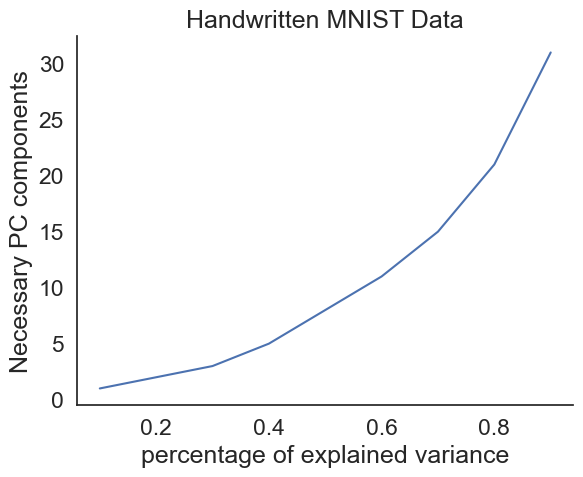

In [8]:
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],var_per)
plt.xlabel('percentage of explained variance')
plt.ylabel('Necessary PC components')
plt.title('Handwritten MNIST Data')
plt.show()

In [9]:
shuffled_X = X #Shuffling values of each digit
for i in range(1797):
    np.random.shuffle(shuffled_X[i])

In [10]:
var_per_shuffled = []
for i in range(1,10):
    num = number_of_PC(i/10,shuffled_X)
    var_per_shuffled.append(num)

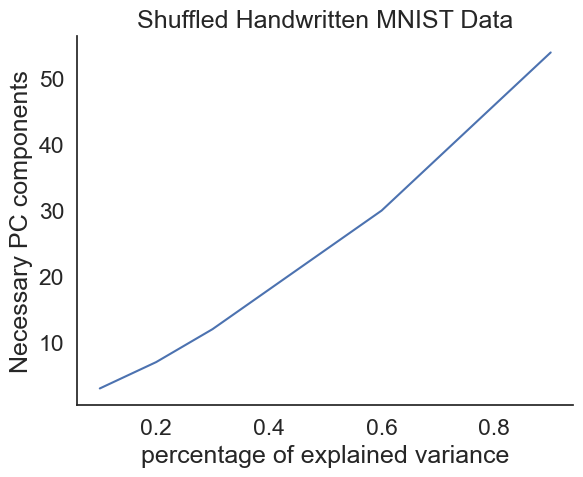

In [11]:
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],var_per_shuffled)
plt.xlabel('percentage of explained variance')
plt.ylabel('Necessary PC components')
plt.title('Shuffled Handwritten MNIST Data')
plt.show()

When comparing the number of necessary PC values (note Y axis values are higher for shuffled data) the shuffled data in general requires more values to reach the same explained variance ratio as the real data. Also the relationship between percentage of explained variance and PC components is more linear for the shuffled data.

## Exercise 2

In [17]:
import pickle

with open('behaviour.pickle', 'rb') as handle:
    behaviour_data = pickle.load(handle)

voltage_signal = np.load('voltage_signal.npy')
cortex_mask = np.load('cortex_mask.npy')

In [13]:
X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:,cortex_mask] # select only cortex pixels, returns a flattened image

In [14]:
pca = PCA(n_components=50);
pca.fit(X)

PCA(n_components=50)

Using code from the lesson we generate the 'cortical_pca' function which gives a plot of a certain PC for a certain behaviour.

In [76]:
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d

PCs = pca.components_[:50,:].T # select and transpose first 50 PCs weights
Y = X @ PCs # compute the PC timecourse, by projecting the original data on each component

framerate = 50. #in Hz

In [108]:
def cortical_pca(behaviour, comp, start_time, end_time): # timecourse as a function of behaviour, PC component, time relative to onset and time relative to offset
  
    frame_times = behaviour_data['frames'] #frame times
    
    peri_Y = [] #empty list for peri-lick timecourses
    
    plt.figure(figsize=(10,5))
    
    if behaviour == 'Lick':
        plt.ylim(-1,1)
        #cycle over licking onsets
        for i in behaviour_data['Lick']:
            onset_frame = np.argmin(abs(frame_times-i)) #take frame closest to onset
            start_frame = int(onset_frame + framerate*start_time/1.000) # compute starting frame
            end_frame = int(onset_frame + framerate*end_time/1.000) # compute ending frame
            peri_Y.append(Y[start_frame:end_frame]) #saves the slice of Y

    elif behaviour == 'CSp':
        plt.ylim(-5,5)
        for i in behaviour_data['CSp']:
            onset_frame = np.argmin(abs(frame_times-i))
            start_frame = int(onset_frame + framerate*start_time/1.000)
            end_frame = int(onset_frame + framerate*end_time/1.000)
            peri_Y.append(Y[start_frame:end_frame])

    elif behaviour == 'CSn':
        plt.ylim(-5,5)
        for i in behaviour_data['CSn']:
            onset_frame = np.argmin(abs(frame_times-i))
            start_frame = int(onset_frame + framerate*start_time/1.000)
            end_frame = int(onset_frame + framerate*end_time/1.000)
            peri_Y.append(Y[start_frame:end_frame])

    else:
        return 'behaviour not recognised'
    
    peri_Y = np.asarray(peri_Y) 
    
    mean_Y = np.mean(peri_Y,axis=0) #average over action
    error = sem(peri_Y,axis=0) #compute sem over action

    
    t = np.linspace(start_time,end_time,int((end_time-start_time)*framerate))
    y = mean_Y[:,comp-1]
    err = error[:,comp-1]
    
    y = gaussian_filter1d(y,2)
    err = gaussian_filter1d(err,2)
    
    plt.plot(t,y)
    plt.fill_between(t,y-err,y+err,alpha=0.2)
    
    plt.xlabel('Time (s)')
    plt.ylabel('PC activation (a.u.)')
    plt.axvline(x=0,linestyle='--',label='Onset')
    plt.legend()
    plt.title(f'{behaviour}, PCA component: {comp}')
    return plt.show()

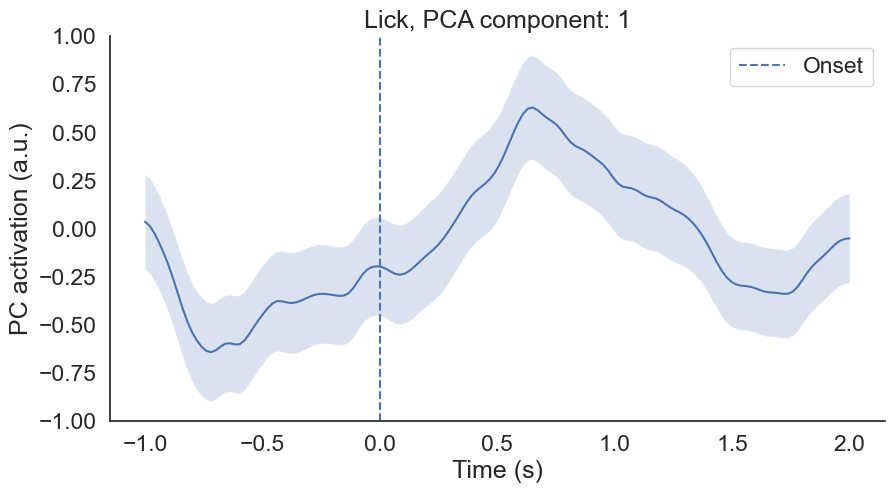

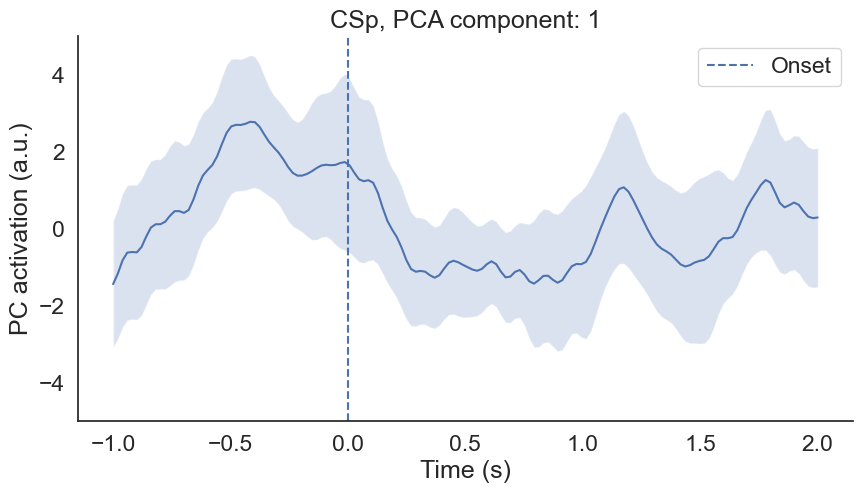

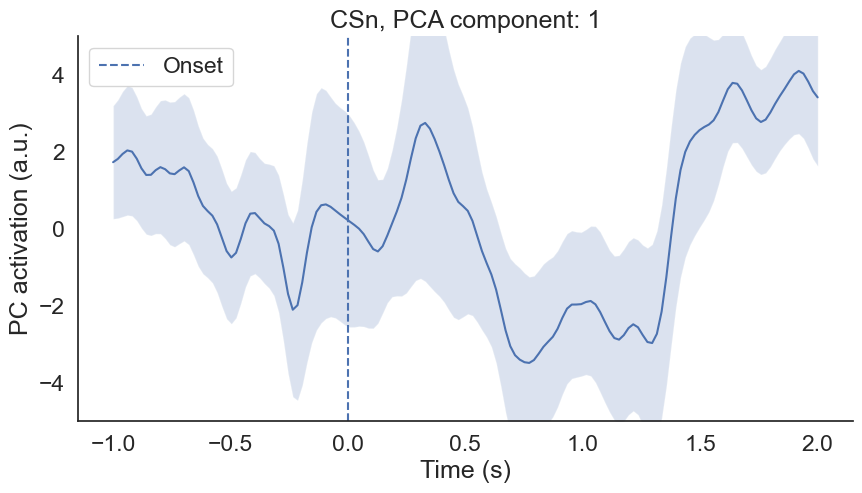

In [126]:
cortical_pca('Lick',1 , -1, 2)
cortical_pca('CSp', 1, -1, 2)
cortical_pca('CSn', 1, -1, 2)

When exploring the data the first thing noticed is that the absolute PC activation for Licks (1< for first component) is in general lower than for CSps (max ~2 for first component) and CSns (max ~4 for first component).

Plotting the PCs 1, 3, 5, 7, and 9 for the Lick action below.

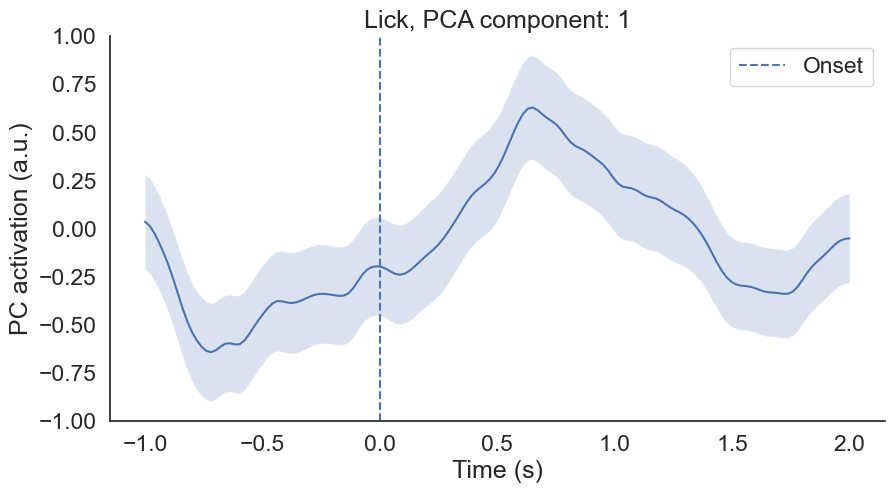

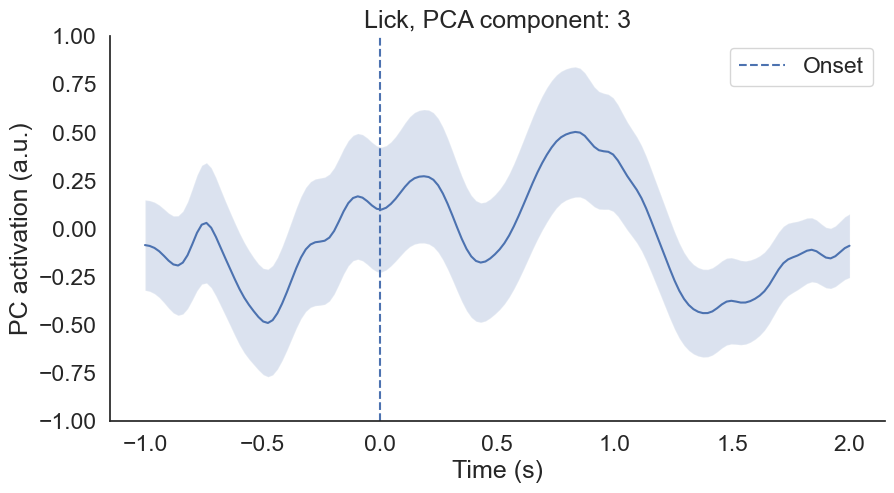

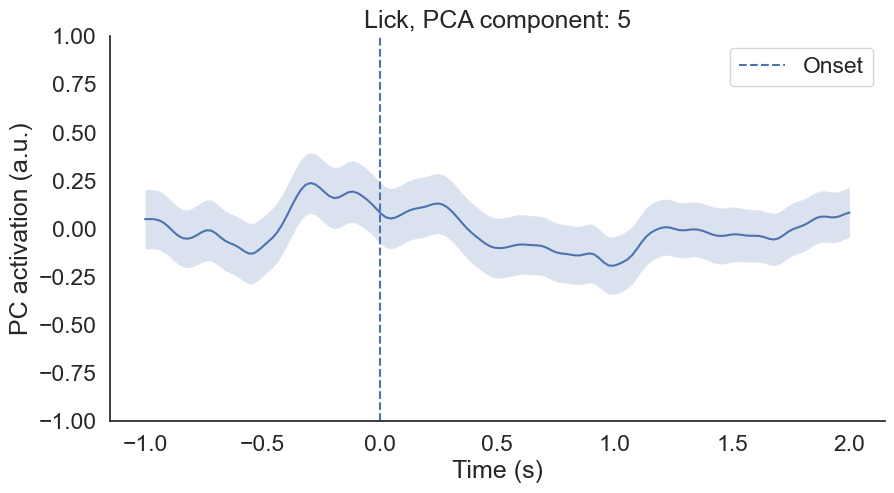

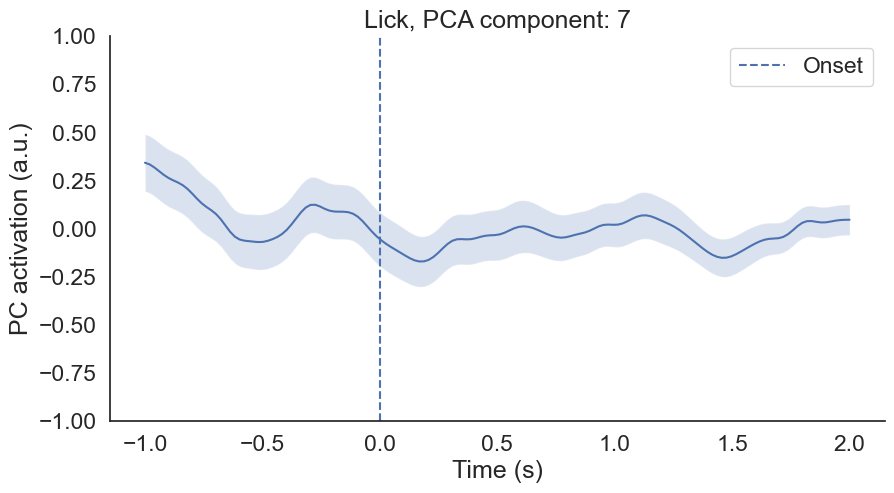

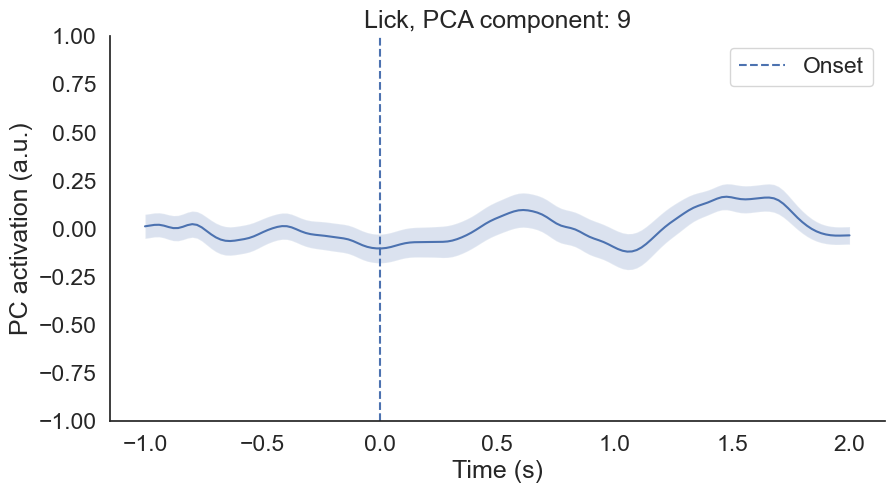

In [127]:
cortical_pca('Lick',1 , -1, 2)
cortical_pca('Lick',3 , -1, 2)
cortical_pca('Lick',5 , -1, 2)
cortical_pca('Lick',7 , -1, 2)
cortical_pca('Lick',9 , -1, 2)

As can be seen in the plots, the PC activation goes down for increasing PC number. The CSn and CSp actions also show this behaviour. This could be tested for with a EVR plot.

## Exercise 3

In [133]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

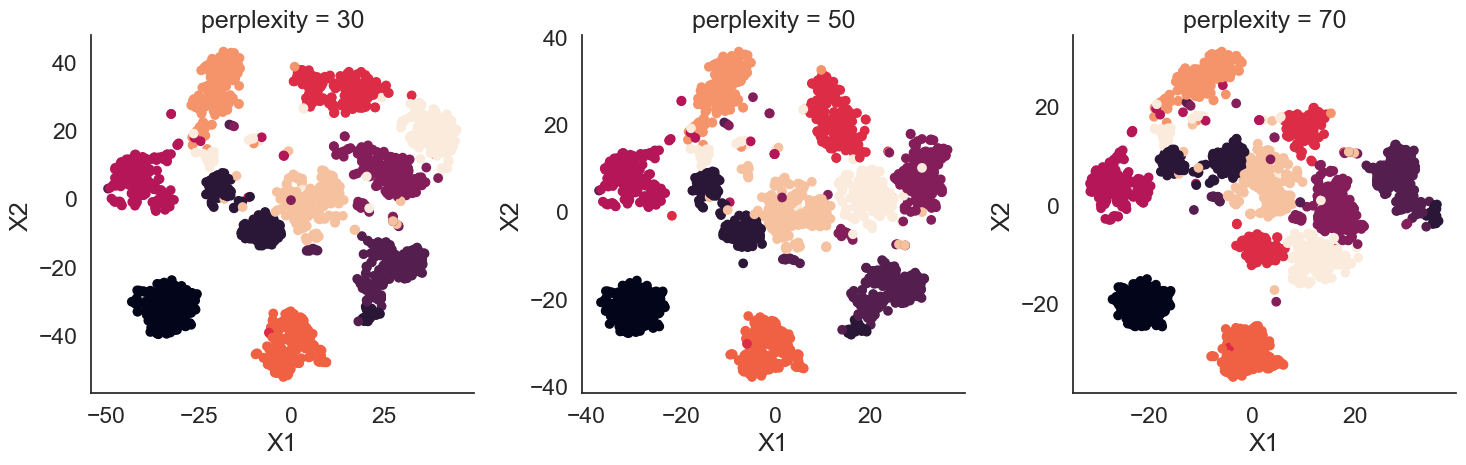

In [147]:
tsne_0 = TSNE(n_components=2,random_state=0)
tsne_1 = TSNE(n_components=2,random_state=0, perplexity = 50)
tsne_2 = TSNE(n_components=2,random_state=0, perplexity = 70)

X_tsne0 = tsne_0.fit_transform(X)
X_tsne1 = tsne_1.fit_transform(X)
X_tsne2 = tsne_2.fit_transform(X)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(X_tsne0[:,0],X_tsne0[:,1],c=dataset.target)
plt.title('perplexity = 30')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_tsne1[:,0],X_tsne1[:,1],c=dataset.target)
plt.title('perplexity = 50')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_tsne2[:,0],X_tsne2[:,1],c=dataset.target)
plt.title('perplexity = 70')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()

As can be seen above, increasing the perplexity has the most influence the groups with higher X1 component values.

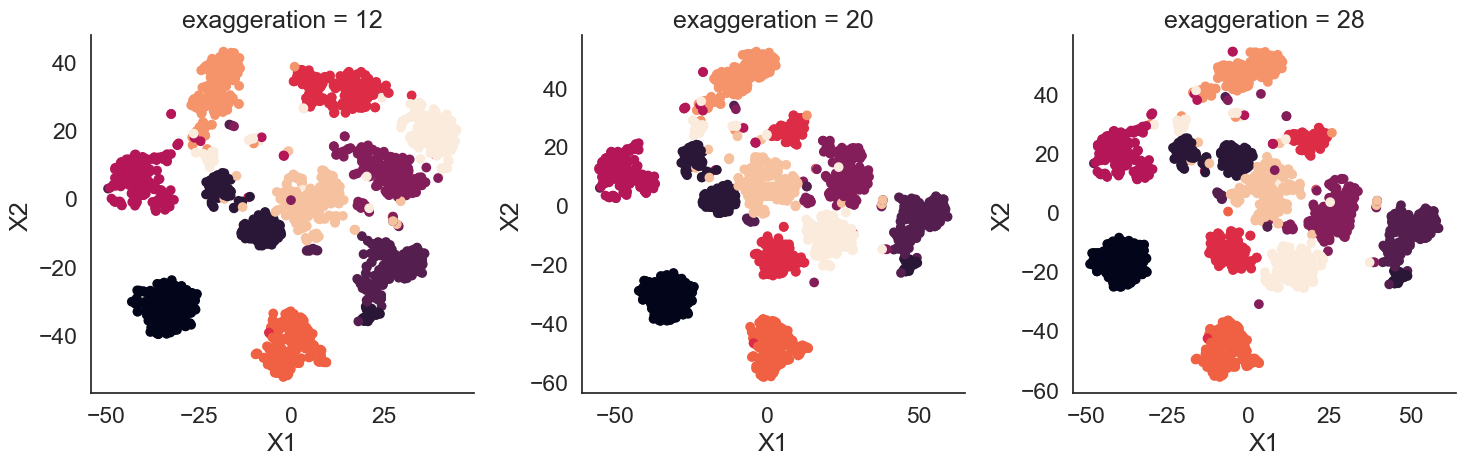

In [146]:
tsne_0 = TSNE(n_components=2,random_state=0)
tsne_1 = TSNE(n_components=2,random_state=0, early_exaggeration=20)
tsne_2 = TSNE(n_components=2,random_state=0, early_exaggeration=28)

X_tsne0 = tsne_0.fit_transform(X)
X_tsne1 = tsne_1.fit_transform(X)
X_tsne2 = tsne_2.fit_transform(X)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(X_tsne0[:,0],X_tsne0[:,1],c=dataset.target)
plt.title('exaggeration = 12')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_tsne1[:,0],X_tsne1[:,1],c=dataset.target)
plt.title('exaggeration = 20')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_tsne2[:,0],X_tsne2[:,1],c=dataset.target)
plt.title('exaggeration = 28')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()

Increasing the exaggeration seems make the central cluster more dense while the groups on the edges remain mostly unchanged.

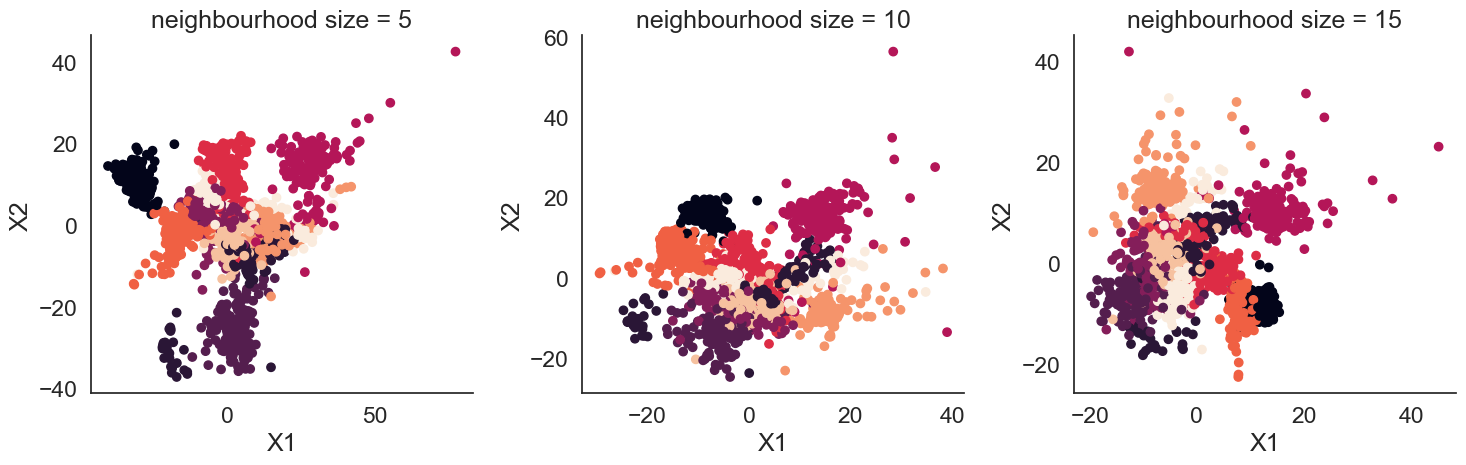

In [145]:
isomap_0 = Isomap(n_components=2, n_neighbors=5)
isomap_1 = Isomap(n_components=2, n_neighbors=10)
isomap_2 = Isomap(n_components=2, n_neighbors=15)

X_iso0 = isomap_0.fit_transform(X)
X_iso1 = isomap_1.fit_transform(X)
X_iso2 = isomap_2.fit_transform(X)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(X_iso0[:,0],X_iso0[:,1],c=dataset.target)
plt.title('neighbourhood size = 5')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_iso1[:,0],X_iso1[:,1],c=dataset.target)
plt.title('neighbourhood size = 10')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_iso2[:,0],X_iso2[:,1],c=dataset.target)
plt.title('neighbourhood size = 15')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()

Increasing the neighbourhood size mostly seems to switch some groups in position.